In [125]:
import numpy as np
import cv2
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import NearestNeighbors
import open3d as o3d
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import os
from sklearn.neighbors import NearestNeighbors
from sklearn import cluster
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from PIL import Image, ImageChops

depth_np = np.load('./depth_translation_glasses.npy')
colour_np = np.load('./colour_translated_glasses.npy')

# depth_np = np.load('/Users/isabelfrolick/Comp558_FinalProject/Comp558_FinalProject/Facial_Reconstruction_Project/outputs/mask6/depth.npy')
# colour_np = np.load('/Users/isabelfrolick/Comp558_FinalProject/Comp558_FinalProject/Facial_Reconstruction_Project/outputs/mask6/colour.npy')

# depth_np = np.load('/Users/isabelfrolick/Downloads/no_movement/depth.npy')
# colour_np = np.load('/Users/isabelfrolick/Downloads/no_movement/colour.npy')
#Complete orioginal: 22, 164
#Naiive redo, mask: 53, 245
#Naive redo, glasses: 13, 274
# colour_img1 = colour_np[53]
# colour_img2 = colour_np[245]
# depth_img1 = depth_np[53]
# depth_img2 = depth_np[245]




colour_img1 = colour_np[2]
colour_img2 = colour_np[15]
depth_img1 = depth_np[2]
depth_img2 = depth_np[15]


## Step 1: Visualize + Normalize Depth

### Step 1a: Visualize Images

(240, 320)


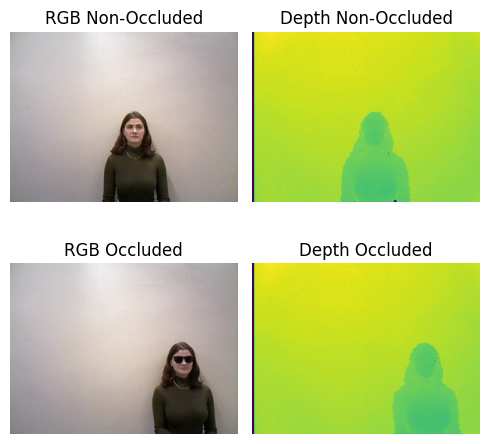

In [126]:
plt.figure(figsize=(5, 5))

plt.subplot(2, 2, 1)
plt.imshow(colour_img1)
plt.title("RGB Non-Occluded")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.imshow(depth_img1)
plt.title("Depth Non-Occluded")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(colour_img2)
plt.title("RGB Occluded")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(depth_img2)
plt.title("Depth Occluded")
plt.axis("off")

plt.tight_layout()
print(depth_img2.shape)

##### Visualize as HSV

(240, 320, 3)


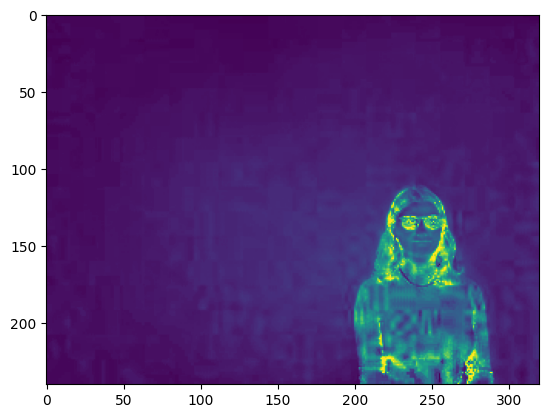

In [127]:
hsvImg = cv2.cvtColor(colour_img2, cv2.COLOR_RGB2HSV)
print(hsvImg.shape)
plt.imshow(hsvImg[:,:,1])

### Step 1b: Normalize + Convolve Depth Images to Remove Data Error 

In [128]:
# depth_img1_int16 = depth_img1.astype('uint16')

# plt.imshow(depth_img1_int16)

# mask = (depth_img1 >= 1000) & (depth_img1 <= 1500)

# # Set pixels outside this range to 0
# depth_img1[~mask] = 0

# mask = (depth_img2 >= 1000) & (depth_img2 <= 1500)

# # Set pixels outside this range to 0
# depth_img2[~mask] = 0

# plt.imshow(depth_img2)
# plt.colorbar()

##### Check which pixels are kept

Mean Depth: 1475.9654296875
Number of points more than 300 outside of the average depth: 732


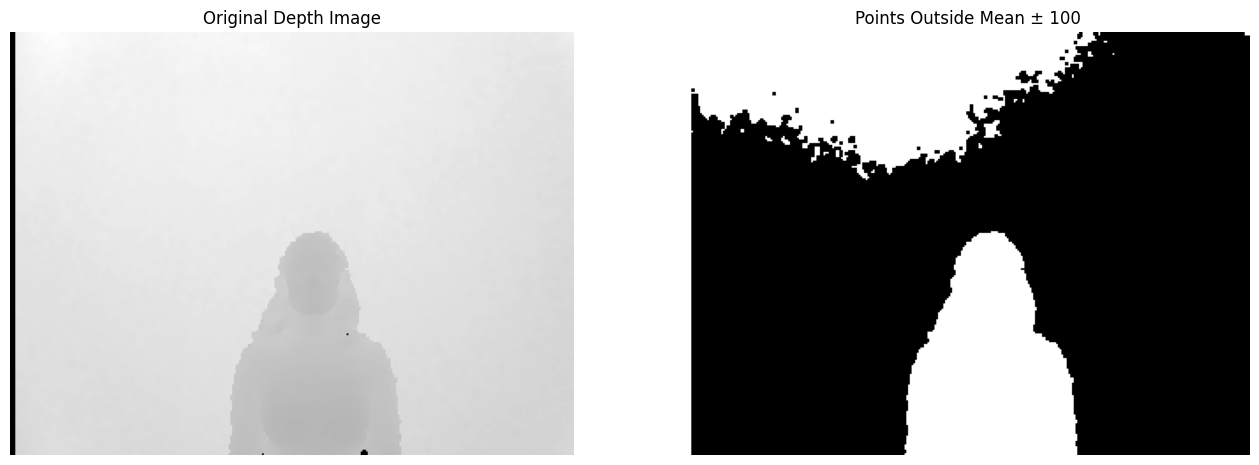

In [129]:
mean_depth = np.mean(depth_img1)

# Find the number of points outside the range (mean ± 100)
threshold = 300
outside_points = np.sum((depth_img1 < mean_depth - threshold) | (depth_img1 > mean_depth + threshold))

print(f"Mean Depth: {mean_depth}")
print(f"Number of points more than {threshold} outside of the average depth: {outside_points}")

threshold = 100

# Create a mask for points outside the range (mean ± 100)
mask = (depth_img1 < mean_depth - threshold) | (depth_img1 > mean_depth + threshold)

# Plot the original depth image
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.imshow(depth_img1, cmap='gray')
plt.title("Original Depth Image")
plt.axis("off")

# Highlight the points outside the range in a binary image
highlighted_image = np.zeros_like(depth_img1)  # Create a blank image
highlighted_image[mask] = 255  # Mark the outliers in white

plt.subplot(1, 2, 2)
plt.imshow(highlighted_image, cmap='gray')
plt.title(f"Points Outside Mean ± {threshold}")
plt.axis("off")
plt.show()


## Step 2: Convert the Depth Images to Point Clouds 

#### Functions for Point Clouds

In [130]:

def create_point_cloud_from_images(color_img, depth_img, intrinsics):
    """
    Create a point cloud from a color image and a depth image using the camera intrinsics.
    
    Args:
        color_img (np.ndarray): RGB image (H, W, 3).
        depth_img (np.ndarray): Depth image (H, W) in meters.
        intrinsics (dict): Camera intrinsics with keys: fx, fy, cx, cy.
        
    Returns:
        open3d.geometry.PointCloud: The generated point cloud.
    """
    h, w = depth_img.shape
    max_depth = 2.0
    # Generate pixel grid
    i, j = np.meshgrid(np.arange(w), np.arange(h))  # Pixel indices
    z = depth_img.flatten()  # Depth values
    x = -(j.flatten() - intrinsics['cx']) * z / intrinsics['fx']
    y = (i.flatten() - intrinsics['cy']) * z / intrinsics['fy']

    # Filter out invalid points (where depth is 0)
    valid = z > 0  & (z < max_depth)
    points = np.vstack((x[valid], y[valid], z[valid])).T

    # Map colors to points
    colors = color_img.reshape(-1, 3)[valid] / 255.0  # Normalize RGB to [0, 1]

    # Create Open3D PointCloud object

    num_points = min(100000, points.shape[0])  # Limit to 100,000 points
    indices = np.random.choice(points.shape[0], num_points, replace=False)
    sampled_points = points[indices]
    sampled_colors = colors[indices]

    point_cloud = o3d.geometry.PointCloud()
    point_cloud.points = o3d.utility.Vector3dVector(sampled_points)
    point_cloud.colors = o3d.utility.Vector3dVector(sampled_colors)

    return point_cloud



In [131]:
# Visualize the point clouds

# Function to handle the 'Q' key press for closing the window
def close_window(vis):
    print("Closing the window")
    vis.destroy_window()

def visualizePointCloud(pcd):
    vis = o3d.visualization.VisualizerWithKeyCallback()
    vis.create_window()

    # Add the point cloud to the visualizer
    vis.add_geometry(pcd)
    # Create and add the coordinate axes to the visualizer
    axis = o3d.geometry.TriangleMesh.create_coordinate_frame(size=300, origin=[0, 0, 0])
    vis.add_geometry(axis)

    
    # Bind the 'Q' key to close the window
    vis.register_key_callback(ord('Q'), close_window)

    # Start the visualization
    vis.run()


#### Create Point Clouds + Visualize for Original Depth Images

In [132]:
# Intrinsic parameters of your camera
intrinsics = {
    'fx': 583.2829786373293,  # Focal length in x (example)
    'fy': 579.4112549695428,  # Focal length in y (example)
    'cx': 320.0 /2,  # Principal point x (example)
    'cy': 240.0/2,  # Principal point y (example)
}


# Create point clouds
pcd1 = create_point_cloud_from_images(colour_img1, depth_img1, intrinsics)
pcd2 = create_point_cloud_from_images(colour_img2, depth_img2, intrinsics)

visualizePointCloud(pcd1)
visualizePointCloud(pcd2)
# Save point clouds as .ply files (or any other format like .pcd, .xyz)
o3d.io.write_point_cloud("point_cloud1.ply", pcd1)
# o3d.io.write_point_cloud("point_cloud2.ply", pcd2)

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Closing the window
[Open3D WARNING] GLFW Error: The GLFW library is not initialized
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
Closing the window
[Open3D WARNING] GLFW Error: The GLFW library is not initialized


True

##### TODO: Try to clump the pixels to fill in the point clouds?

## Step 3: Get Keypoints and Corresponding Features between Images

There are a few ways to do this: we can either do it in 2D using the depth images, which is computationally faster, or in 3D using the Point Clouds. We have tried both ways below. 

### Step 3a: Get Corresponding Features in 2D

Extract keypoint coordinates and matches them

In [133]:

def getCorrespondingKeypoint2D(depth_img1, depth_img2, tolerance):
    # Convert depth images to uint8 for visualization and keypoint detection
    depth_img1_vis = cv2.normalize(depth_img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_img2_vis = cv2.normalize(depth_img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Detect keypoints using ORB
    orb = cv2.ORB_create()
    kp1 = orb.detect(depth_img1_vis, None)
    kp2 = orb.detect(depth_img2_vis, None)

    # Extract coordinates of keypoints
    coords1 = np.array([kp.pt for kp in kp1])  
    coords2 = np.array([kp.pt for kp in kp2])  
    # Compare coordinates to find matches
    matches = []
    distances = []
    for i, pt1 in enumerate(coords1):
        for j, pt2 in enumerate(coords2):
            if np.allclose(pt1, pt2, atol=tolerance):  # small tolerance
                matches.append((pt1, pt2))  
                distance = np.linalg.norm(pt1 - pt2)
                distances.append(distance)
    
   
       # Store matches as (x, y, depth) tuples
    img1_matches = []
    img2_matches = []
    for pt1, pt2 in matches:
        x1, y1 = int(pt1[0]), int(pt1[1])
        x2, y2 = int(pt2[0]), int(pt2[1])
        
        depth1 = depth_img1[y1, x1]  # Get depth value from original depth image
        depth2 = depth_img2[y2, x2]  # Get depth value from original depth image
        
        img1_matches.append((x1, y1, depth1))
        img2_matches.append((x2, y2, depth2))
    return img1_matches, img2_matches, distances

def visualizeKeypoints(depth_img1, depth_img2, coords1, coords2):
    depth_img1_vis = cv2.normalize(depth_img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_img2_vis = cv2.normalize(depth_img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

        # Plot the images with matching keypoints
    plt.figure(figsize=(10, 5))
    colours = plt.cm.jet(np.linspace(0, 1, len(coords1)))    
    # Plot depth_img1 with matching keypoints
    plt.subplot(1, 2, 1)
    plt.imshow(depth_img1_vis, cmap='gray')
    if len(coords1) > 0:
        for i, (x, y, _) in enumerate(coords1):
            plt.plot(x, y, 'o', colours[i])  # Plot keypoints in red
    plt.title("Keypoints on Depth Image 1")
    plt.axis('off')

    # Plot depth_img2 with matching keypoints
    plt.subplot(1, 2, 2)
    plt.imshow(depth_img2_vis, cmap='gray')
    if len(coords2) > 0:
        for i, (x, y, _) in enumerate(coords2):
            plt.plot(x, y, 'o', colours[i])  # Plot keypoints in red
    plt.title("Matching Keypoints on Depth Image 2")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [134]:
def matchingDepthFeatures(depth_img1, depth_img2):
    #Define window size for local region comparison (e.g., 5x5)
    window_size = 5
    half_window = window_size // 2

    # Initialize list for corresponding keypoints
    matches = []

    # Loop through each pixel in depth_img1
    for y in range(half_window, depth_img1.shape[0] - half_window):
        for x in range(half_window, depth_img1.shape[1] - half_window):
            
            # Extract depth value of the current pixel in image 1
            depth_value1 = depth_img1[y, x]
            
            # Define the search window in both images
            window1 = depth_img1[y - half_window : y + half_window + 1, x - half_window : x + half_window + 1]
            window2 = depth_img2[y - half_window : y + half_window + 1, x - half_window : x + half_window + 1]
            
            # Compute the similarity measure (e.g., Mean Squared Error) between the windows
            mse = np.sum((window1 - window2) ** 2)
            
            # Set a threshold for matching windows (you may need to adjust this threshold)
            if mse < 100:  # Example threshold for similarity, tune as necessary
                matches.append(((x, y), mse))

    # Sort matches by similarity score (lower MSE means more similar)
    matches = sorted(matches, key=lambda match: match[1])
    depth_img1_vis = cv2.normalize(depth_img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_img2_vis = cv2.normalize(depth_img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Plot the results
    img_matches = cv2.drawKeypoints(depth_img1_vis, [cv2.KeyPoint(m[0][0], m[0][1], 1) for m in matches], None, color=(0, 255, 0))

    plt.imshow(img_matches, cmap='gray')
    plt.title("Matched Keypoints Between Depth Images")
    plt.show()

    # Optionally, you can visualize matches as lines connecting corresponding points
    for match in matches[:10]:  # Display top 10 matches
        pt1 = match[0]  # Coordinates from depth_img1
        pt2 = match[0]  # Coordinates from depth_img2
        plt.plot([pt1[0], pt2[0]], [pt1[1], pt2[1]], 'ro-')  # Draw red lines between matching points
    plt.imshow(depth_img1, cmap='gray')
    plt.title("Matched Points Visualization")
    plt.show()

#### Older Methods for Keypoints

In [135]:
# #Based on mins and maxs of depth image
# # min_depth = 1380
# # max_depth = 1700
# min_depth = 1000
# max_depth = 1400

# # Mask the depth image
# depth_mask1 = (depth_img1 >= min_depth) & (depth_img1 <= max_depth)

# # Create a canvas with the same size as the depth image (black by default)
# image1_cropped = np.zeros_like(colour_img1)

# # Loop through the pixels of the color image and apply the depth mask
# for y in range(colour_img1.shape[0]):
#     for x in range(colour_img1.shape[1]):
#         if depth_mask1[y, x]:  # If depth is within the desired range
#             image1_cropped[y, x] = colour_img1[y, x]  # Copy the color from the original image
#         else:
#             image1_cropped[y, x] = (0, 0, 0)  # Set the pixel to black if outside the range


# depth_img1_mask = np.zeros_like(depth_img1)
# for y in range(depth_img2.shape[0]):
#     for x in range(depth_img2.shape[1]):
#         if depth_mask1[y, x] == 0:  # If depth is within the desired range
#             depth_img1_mask[y, x] = 0  # Copy the color from the original image
#         else:
#             depth_img1_mask[y, x] = depth_img2[y,x] # Set the pixel to black if outside the range




# plt.imshow(image1_cropped)
# #canvas[depth_mask] = colour_img1  # You can adjust this value for visualization (e.g., color or intensity)


In [136]:
# #Based on mins and maxs of depth image
# # min_depth = 1380
# # max_depth = 1700
# min_depth = 1000
# max_depth = 1370

# # Mask the depth image
# depth_mask2 = (depth_img2 >= min_depth) & (depth_img2 <= max_depth)

# # Create a canvas with the same size as the depth image (black by default)
# image2_cropped = np.zeros_like(colour_img2)

# # Loop through the pixels of the color image and apply the depth mask
# for y in range(colour_img2.shape[0]):
#     for x in range(colour_img2.shape[1]):
#         if depth_mask2[y, x]:  # If depth is within the desired range
#             image2_cropped[y, x] = colour_img2[y, x]  # Copy the color from the original image
#         else:
#             image2_cropped[y, x] = (0, 0, 0)  # Set the pixel to black if outside the range


# depth_img2_mask = np.zeros_like(depth_img2)
# for y in range(depth_img2.shape[0]):
#     for x in range(depth_img2.shape[1]):
#         if depth_mask2[y, x] == 0:  # If depth is within the desired range
#             depth_img2_mask[y, x] = 0  # Copy the color from the original image
#         else:
#             depth_img2_mask[y, x] = depth_img2[y,x] # Set the pixel to black if outside the range



# plt.imshow(image2_cropped)
# #canvas[depth_mask] = colour_img1  # You can adjust this value for visualization (e.g., color or intensity)


In [137]:
# type(depth_img2_mask)

### Step 3b: Feature Detection

Could always add something to use the SIFT orientation/ scale to find matches (in keypoints)

In [138]:
def getSIFTFeatures(depth_img1, depth_img2):
    depth_img1 = cv2.normalize(depth_img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_img2 = cv2.normalize(depth_img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)


    # Initialize the SIFT detector
    sift = cv2.SIFT_create(contrastThreshold=0.006, edgeThreshold=15)

    # Detect keypoints and compute descriptors for both images
    keypoints1, features1 = sift.detectAndCompute(depth_img1, None)
    keypoints2, features2 = sift.detectAndCompute(depth_img2, None)
    print("Features1 shape:", features1.shape)  # Should be a non-empty array
    print("Features2 shape:", features2.shape) 
    # FLANN-based matcher parameters
    # Use FLANN (Fast Library for Approximate Nearest Neighbors) for feature matching
    index_params = dict(algorithm=3, trees=50)  # Use a KDTree index (algorithm=0) with 10 trees
    search_params = dict(checks=200)  # Number of checks to perform (higher is more accurate but slower)

    # Perform feature matching using FLANN-based matcher
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(features1, features2, k=2)  # k=2 means finding the two best matches for each keypoint

    # Apply ratio test (Lowe's ratio test) to filter out weak matches
    good_matches = []
    for m, n in matches:
        if m.distance < 0.6 * n.distance:  # LOWER is more strict
            good_matches.append(m)

    # Draw the good matches on the images
    img_matches = cv2.drawMatches(depth_img1, keypoints1, depth_img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the result
    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.axis("off")
    return good_matches, keypoints1, keypoints2, features1, features2
    # cv2.imshow('Keypoint Matches', img_matches)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


In [139]:
def getORBFeatures(depth_img1, depth_img2):

    # Normalize depth images to the range [0, 255] and convert to uint8
    depth_img1 = cv2.normalize(depth_img1, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    depth_img2 = cv2.normalize(depth_img2, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Initialize the ORB detector
    orb = cv2.ORB_create(nfeatures=250)  # You can adjust `nfeatures` for more/less keypoints

    # Detect keypoints and compute descriptors for both images
    keypoints1, features1 = orb.detectAndCompute(depth_img1, None)
    keypoints2, features2 = orb.detectAndCompute(depth_img2, None)

    print("Features1 shape:", features1.shape if features1 is not None else "None")
    print("Features2 shape:", features2.shape if features2 is not None else "None")

    # Use BFMatcher with Hamming distance (default for ORB)
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

    # Perform feature matching
    matches = bf.match(features1, features2)

    # Sort matches by distance (lower distance is better)
    good_matches = sorted(matches, key=lambda x: x.distance)

    # Draw the good matches on the images
    img_matches = cv2.drawMatches(depth_img1, keypoints1, depth_img2, keypoints2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    # Show the result
    plt.figure(figsize=(10, 5))
    plt.imshow(img_matches)
    plt.title("ORB Feature Matching")
    plt.axis("off")
    plt.show()

    return good_matches, keypoints1, keypoints2, features1, features2


##### SIFT Features (not using)

Features1 shape: (38, 128)
Features2 shape: (22, 128)


7

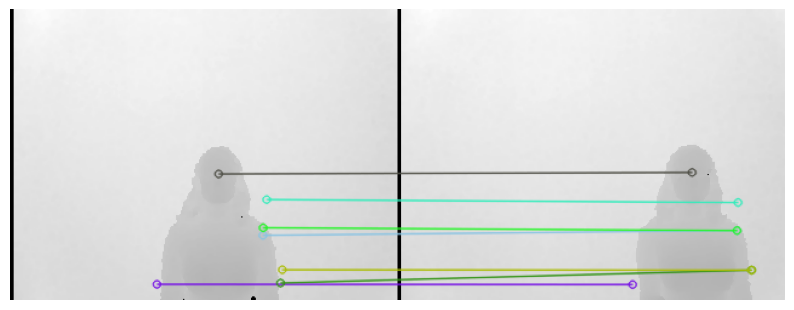

In [140]:
good_matches, keypoints1, keypoints2, features1, features2= getSIFTFeatures(depth_img1, depth_img2)
len(good_matches) #10

#### ORB Feature (using!)

Features1 shape: (39, 32)
Features2 shape: (16, 32)


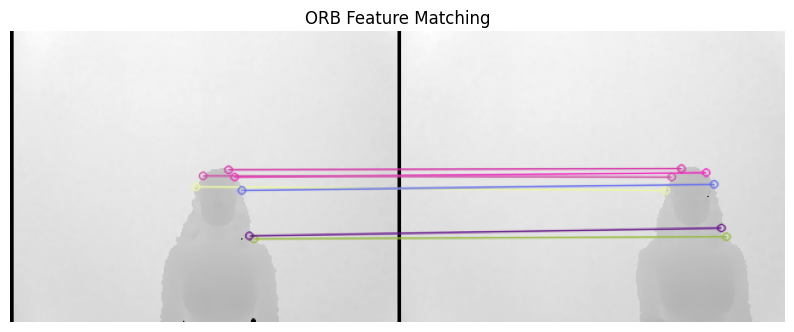

7


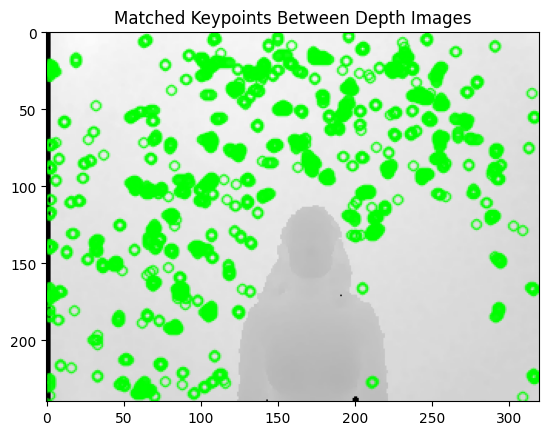

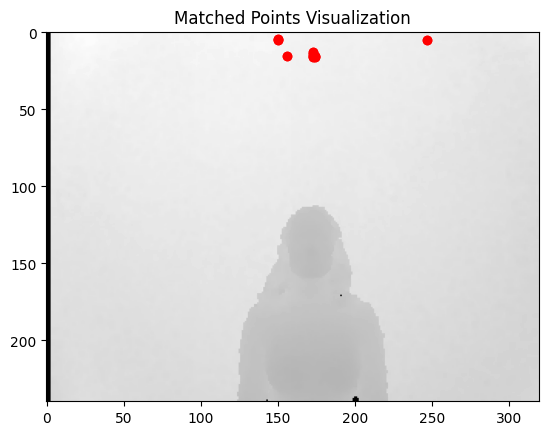

In [141]:
good_matches, keypoints1, keypoints2, features1, features2= getORBFeatures(depth_img1, depth_img2)
print(len(good_matches)) #10

matchingDepthFeatures(depth_img1, depth_img2)
# matching_keypoints_image1, matching_keypoints_image2, distances = getCorrespondingKeypoint2D(depth_img1, depth_img2, tolerance=500)
# avg_mean_distance = np.mean(distances)
# print(avg_mean_distance)
# visualizeKeypoints(depth_img1, depth_img2, matching_keypoints_image1, matching_keypoints_image2)
# len(matching_keypoints_image2)

In [142]:
distances = []
for i, match in enumerate(good_matches):
    print(f'Good Match {i+1}: QueryIdx = {match.queryIdx}, TrainIdx = {match.trainIdx}, Distance = {match.distance}')
    distances.append(match.distance)

mse = np.mean(distances)
print(mse)
good_keypoints1 = [keypoints1[m.queryIdx] for m in good_matches]
good_keypoints2 = [keypoints2[m.trainIdx] for m in good_matches]


Good Match 1: QueryIdx = 7, TrainIdx = 11, Distance = 38.0
Good Match 2: QueryIdx = 9, TrainIdx = 7, Distance = 42.0
Good Match 3: QueryIdx = 2, TrainIdx = 1, Distance = 47.0
Good Match 4: QueryIdx = 6, TrainIdx = 3, Distance = 52.0
Good Match 5: QueryIdx = 10, TrainIdx = 5, Distance = 52.0
Good Match 6: QueryIdx = 20, TrainIdx = 13, Distance = 53.0
Good Match 7: QueryIdx = 34, TrainIdx = 10, Distance = 72.0
50.857142857142854


### Step 3c: Compute the transformation between the images

We can do this a few ways and we're not entirely sure which will work best. 
- Affine transformation 2D
- Affine transformation in 3D


In [143]:
kps1 = []
kps2 = []
# for i, kp in enumerate(good_keypoints1):
#     print(f'Keypoint {i}: (x, y) = ({kp.pt[0]}, {kp.pt[1]}), size = {kp.size}, angle = {kp.angle}')
#     kps1.append((kp.pt[0], kp.pt[1]))


kps1 = np.array([kp.pt for kp in good_keypoints1])  
kps2 = np.array([kp.pt for kp in good_keypoints2])  


##### Affine transformation in 2D
TODO: Get some metrics to define the Affine transformation against ICP

In [144]:
# #M, inliers = cv2.findHomography(kps1, kps2, method=cv2.RANSAC) - for projective registration we need rigid

# K = np.eye(3)  # Identity matrix, replace with actual intrinsic matrix if available
# E, mask = cv2.findEssentialMat(kps1, kps2, K)

affineTransform2D = cv2.estimateAffine2D(kps1, kps2, method=cv2.RANSAC)

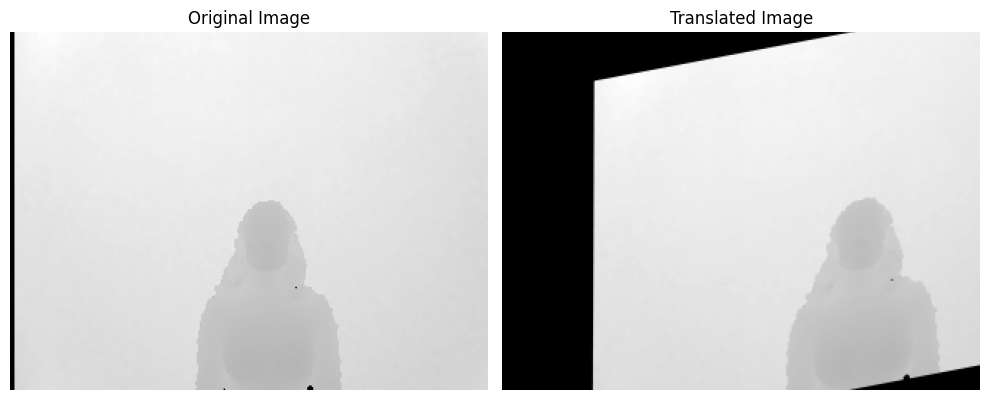

In [145]:
#transformed_points = cv2.transform(np.array([kps1]), affineTransform[0])
height, width = depth_img1.shape

# Apply the affine transformation to the image using warpAffine
translated_img_depth = cv2.warpAffine(depth_img1, affineTransform2D[0], (width, height))
translated_img_colour = cv2.warpAffine(colour_img1, affineTransform2D[0], (width, height))

# Display the original and the transformed image side by side
plt.figure(figsize=(10, 5))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(depth_img1, cmap='gray')
plt.title("Original Image")
plt.axis('off')

# Plot the transformed image
plt.subplot(1, 2, 2)
plt.imshow(translated_img_depth, cmap='gray')
plt.title("Translated Image")
plt.axis('off')

plt.tight_layout()
plt.show()

### Step 3d: Visualize Affine Transformation

TODO: Normalize the transformed image with depth to remove the artifacts from transformed PC

Visually, that looks good! Let's plot the transformed image as a point cloud and the second image as apoint cloud, overlay them in the same space to verify.

Add a convert the transformed point cloud back into depth

In [146]:
import copy

intrinsics = {
    'fx': 583.2829786373293,  # Focal length in x (example)
    'fy': 579.4112549695428,  # Focal length in y (example)
    'cx': 320.0 /2,  # Principal point x (example)
    'cy': 240.0 /2 ,  # Principal point y (example)
}

translated_img_depth_mask = copy.deepcopy(translated_img_depth)
mask = (translated_img_depth >= 1100) & (translated_img_depth <= 1800)

# Set pixels outside this range to 0
translated_img_depth_mask[~mask] = 0

# Create point clouds
translated_pcd1 = create_point_cloud_from_images(translated_img_colour, translated_img_depth_mask, intrinsics)

visualizePointCloud(translated_pcd1)
#Need to get the translated image colour to be transformed the same

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display
[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


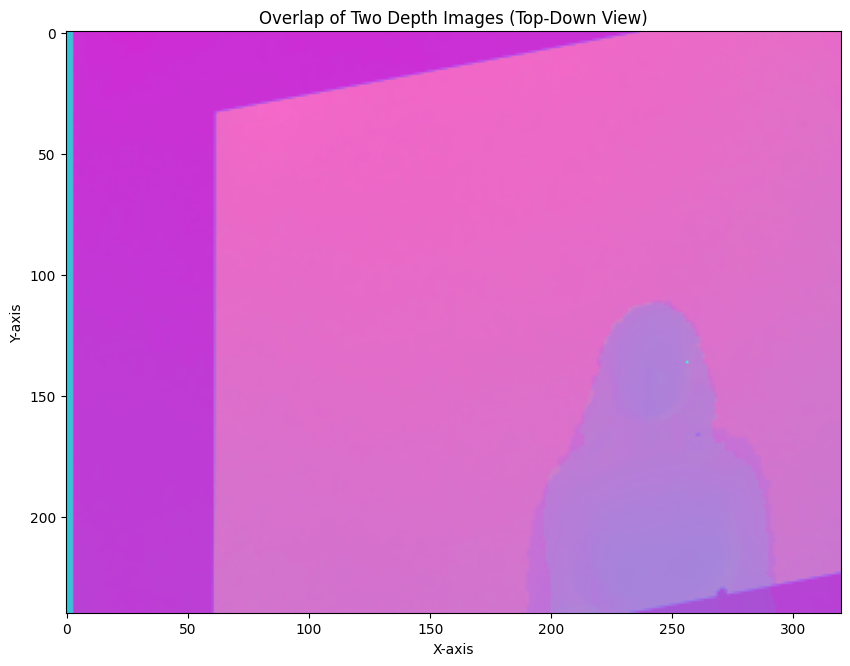

In [147]:
# Generate X, Y coordinates for the depth maps
x = np.arange(translated_img_depth.shape[1])
y = np.arange(translated_img_depth.shape[0])
x, y = np.meshgrid(x, y)

plt.figure(figsize=(10, 8))

# Plot the first depth image
plt.imshow(translated_img_depth, cmap='viridis', alpha=0.6, label="Depth Image 1")

# Overlay the second depth image
plt.imshow(depth_img2, cmap='cool', alpha=0.6, label="Depth Image 2")

# Add a colorbar

# Add labels and title
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.title("Overlap of Two Depth Images (Top-Down View)")

plt.show()


Flaw: The translated image has a bunch of black pixels in it which is going to mess up the RGB image. This is a problem. Instead, take the pixels of the background wall in the original depth_image1 and map them to a new canvas then just put the trasnlated_depth image onto that canvas

#### TODO: Set the background depth pixels to zero as well

## Step 4: Remove the Background from RGB Images + Convert to HSV

 TODO: Try to remove the colour ranges of the background pixels

#### Remove Backgrounds

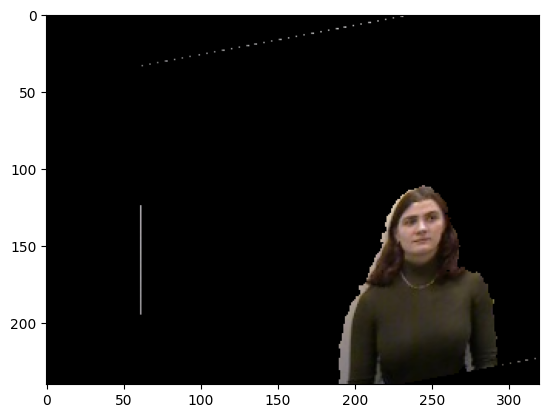

In [148]:
#Based on mins and maxs of depth image
min_depth = 1000
max_depth = 1380

# Mask the depth image
depth_mask = (translated_img_depth >= min_depth) & (translated_img_depth <= max_depth)
plt.imshow(depth_mask)

# Create a canvas with the same size as the depth image (black by default)
image1_cropped = np.zeros_like(translated_img_colour)

# Loop through the pixels of the color image and apply the depth mask
for y in range(translated_img_colour.shape[0]):
    for x in range(translated_img_colour.shape[1]):
        if depth_mask[y, x]:  # If depth is within the desired range
            image1_cropped[y, x] = translated_img_colour[y, x]  # Copy the color from the original image
        else:
            image1_cropped[y, x] = (0, 0, 0)  # Set the pixel to black if outside the range

plt.imshow(image1_cropped)

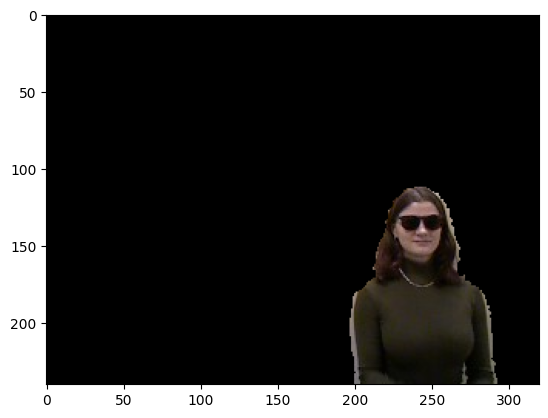

In [149]:
#Based on mins and maxs of depth image
min_depth = 1000
max_depth = 1380

# Mask the depth image
depth_mask = (depth_img2 >= min_depth) & (depth_img2 <= max_depth)

# Create a canvas with the same size as the depth image (black by default)
image2_cropped = np.zeros_like(colour_img2)

# Loop through the pixels of the color image and apply the depth mask
for y in range(colour_img2.shape[0]):
    for x in range(colour_img2.shape[1]):
        if depth_mask[y, x]:  # If depth is within the desired range
            image2_cropped[y, x] = colour_img2[y, x]  # Copy the color from the original image
        else:
            image2_cropped[y, x] = (0, 0, 0)  # Set the pixel to black if outside the range


plt.imshow(image2_cropped)


Now I need the pixels where the masked image is non-black from the original colour image;

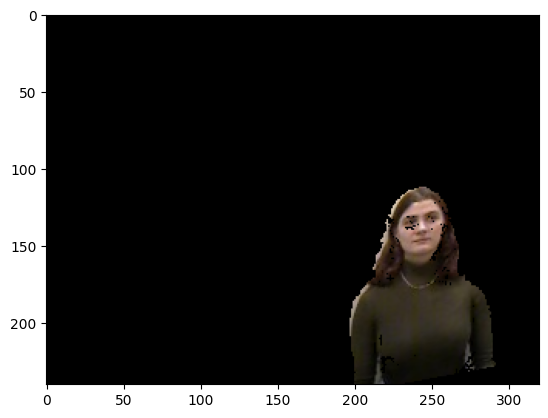

In [150]:
#Gte the pixels where neither is empty (more rigourous)
mask1 = np.all(image1_cropped != [0, 0, 0], axis=-1) 
mask2 = np.all(image2_cropped != [0, 0, 0], axis=-1)  # Non-black pixels in translated_img_colour

mask = (np.all(image1_cropped != [0, 0, 0], axis=-1)  & np.all(image2_cropped != [0, 0, 0], axis=-1) )

# Step 2: Create a copy of the canvas to overlay the image onto
h, w, channels = image1_cropped.shape
transformed_cropped = np.zeros((h, w, channels), dtype=np.uint8)

# Step 3: Use the mask to copy pixels from translated_img_colour to the canvas
transformed_cropped[mask] = translated_img_colour[mask]

# Step 4: Display the result
plt.imshow(transformed_cropped)
plt.show()

#### Convert RGB to HSV (unused)

(240, 320, 3)


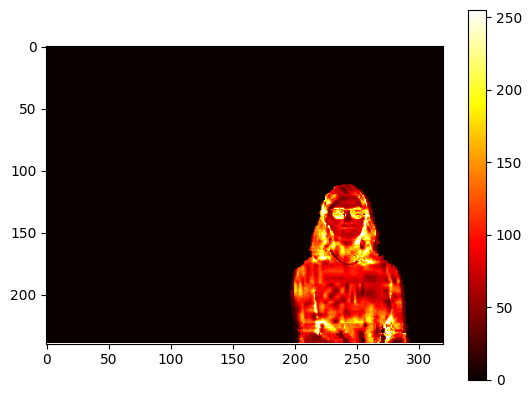

In [151]:
hsvImg2 = cv2.cvtColor(image2_cropped, cv2.COLOR_RGB2HSV)
hsvImg1 = cv2.cvtColor(image1_cropped, cv2.COLOR_RGB2HSV)
hsvTransformed = cv2.cvtColor(transformed_cropped, cv2.COLOR_RGB2HSV)

print(hsvImg.shape)
plt.imshow(hsvImg2[:,:,1], cmap='hot')
plt.colorbar()

In [152]:
# # alpha = 1 # Simple contrast control
# # beta = 1.5  # Simple brightness control - doesn't chnage saturation
# # hsvImg2_cp = np.zeros_like(hsvImg2)

# # for y in range(hsvImg2.shape[0]):
# #     for x in range(hsvImg2.shape[1]):
# #         for c in range(hsvImg2.shape[2]):
# #             hsvImg2_cp[y,x,c] = np.clip(alpha*hsvImg2[y,x,c] + beta, 0, 255)
# #             hsvImg2_cp[y,x,c] = np.clip(alpha*hsvImg2[y,x,c] + beta, 0, 255)


# hue, saturation, value = cv2.split(hsvImg2)

# # Normalize the saturation to stretch its range and increase contrast
# # saturation = cv2.normalize(saturation, None, 0, 255, cv2.NORM_MINMAX)

# # You can apply a nonlinear transformation (e.g., power law) to make the differences in saturation more visible
# gamma = 0.5  # You can adjust gamma to control the emphasis on differences
# saturation = np.power(saturation / 255.0, gamma) * 255.0
# saturation = np.uint8(saturation)

# # enhanced_hsv = cv2.merge([hue, saturation, value])

# plt.subplot(1,2,1)
# plt.imshow(hsvImg2[:,:,1])
# plt.subplot(1,2,2)
# plt.imshow(saturation)
# # plt.imshow(colour_img1)
# # plt.subplot(1,4,4)
# # plt.imshow(copy_colourImage1)

In [153]:
# #Based on mins and maxs of depth image
# # min_depth = 1380
# # max_depth = 1700
# min_depth = 1000
# max_depth = 1370

# channelImage = saturation
# # Mask the depth image
# depth_mask = (depth_img2 >= min_depth) & (depth_img2 <= max_depth)

# # Create a canvas with the same size as the depth image (black by default)
# hue_backgroundWhite = np.zeros_like(channelImage)
# print(hue_backgroundWhite.shape)
# # Loop through the pixels of the color image and apply the depth mask
# for y in range(channelImage.shape[0]):
#     for x in range(channelImage.shape[1]):
#         if depth_mask[y, x]:  # If depth is within the desired range
#             hue_backgroundWhite[y, x] = channelImage[y, x]  # Copy the color from the original image
#         else:
#             hue_backgroundWhite[y, x] = 255  # Set the pixel to black if outside the range
#             # hue_backgroundWhite[y, x] = 0  # Set the pixel to black if outside the range


# plt.imshow(hue_backgroundWhite, cmap='hot')
# #canvas[depth_mask] = colour_img1  # You can adjust this value for visualization (e.g., color or intensity)


## Step 5: Get the Difference between Transformed Image and Original Second Image (RBG)

#### Get the Differences

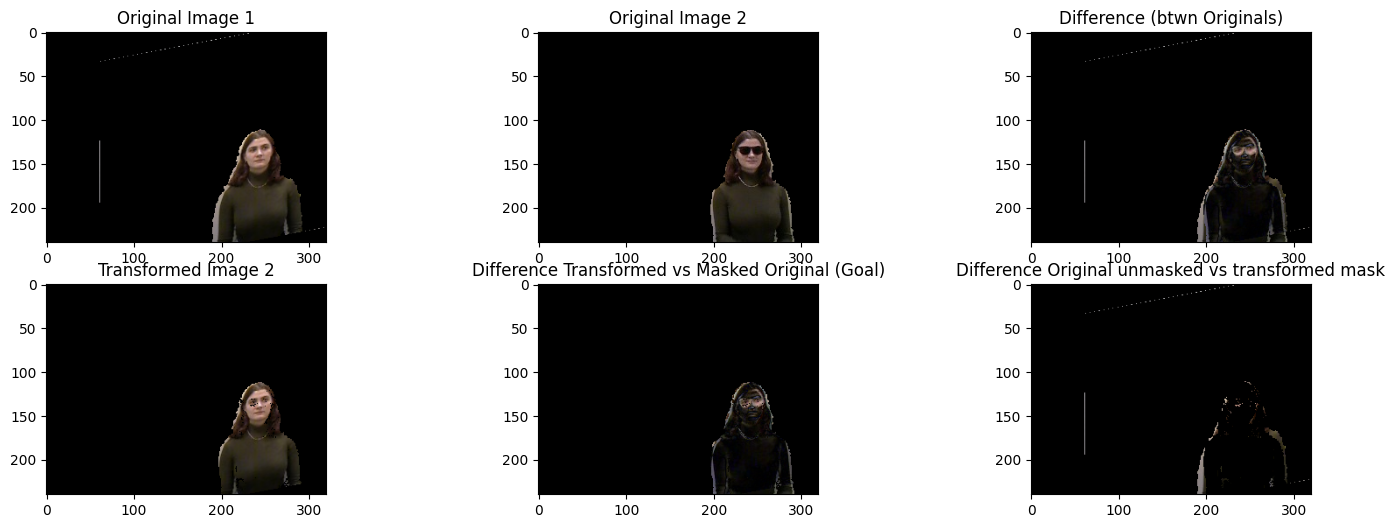

In [154]:

# convert to pillow
col_image1 = Image.fromarray(image1_cropped)
col_image2 = Image.fromarray(image2_cropped)
col_image3 = Image.fromarray(transformed_cropped)

diff_original = ImageChops.difference(col_image1, col_image2) 
diff_trans = ImageChops.difference(col_image2, col_image3) 
diff_og_trans = ImageChops.difference(col_image1, col_image3) 

diff_diff = ImageChops.difference(diff_original, diff_og_trans) 

plt.figure(figsize=(18, 6))

# Plot original image2
plt.subplot(2, 3, 1)
plt.title("Original Image 1")
plt.imshow(col_image1)

# Plot transformed image2
plt.subplot(2, 3, 2)
plt.title("Original Image 2")
plt.imshow(col_image2)

# Plot difference image
plt.subplot(2, 3, 3)
plt.title("Difference (btwn Originals)")
plt.imshow(diff_original)

plt.subplot(2, 3, 4)
plt.title("Transformed Image 2")
plt.imshow(col_image3)

plt.subplot(2, 3, 5)
plt.title("Difference Transformed vs Masked Original (Goal)")
plt.imshow(diff_trans)

plt.subplot(2, 3, 6)
plt.title("Difference Original unmasked vs transformed mask")
plt.imshow(diff_og_trans)

# Convert to grayscale (if not already)
diff_original = diff_original.convert("L")
# Convert the image to a NumPy array
diff_original_array = np.array(diff_original)
# Calculate the sum of pixel values
diff_original_array_sum = np.sum(diff_original_array)

#### Get the BRIGHTNESS channel of the DIFFERENCE image

(240, 320, 3)


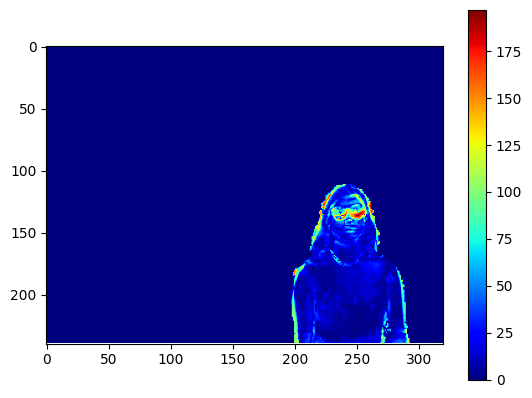

In [155]:
diff = np.array(diff_trans)

hsvImg2_diff = cv2.cvtColor(diff, cv2.COLOR_RGB2HSV)

print(hsvImg2_diff.shape)
plt.imshow(hsvImg2_diff[:,:,2], cmap='jet')
plt.colorbar()

## Step 6: Clustering

diff_trans is the difference between the transformed and the masked images

colour_image2 is the ORIGINAL masked image (RGB)


cropped_image2 is the RGB masked image without a background

hsvImg2 is the cropped (without a background) masked image, as a HSV

hsvImg2[:,:,0] is the HUE image with a max of 179
hsvImg2[:,:,1] is the Saturation channel, max 255
hsvImg2[:,:,2] is the Value channel, max 255

Need the image as a NP array

#### Plot the HSV brightness image again

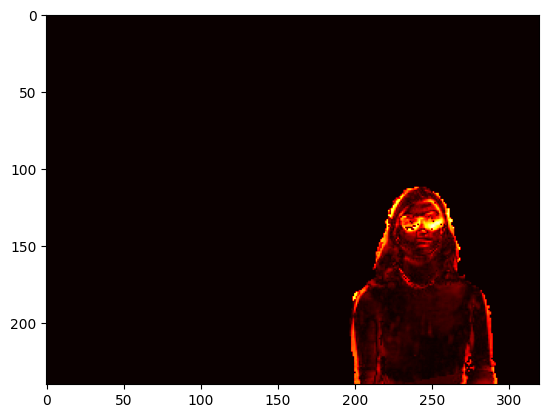

In [156]:
plt.imshow(hsvImg2_diff[:,:,2], cmap='hot')

### Step 6a: K-means Clustering

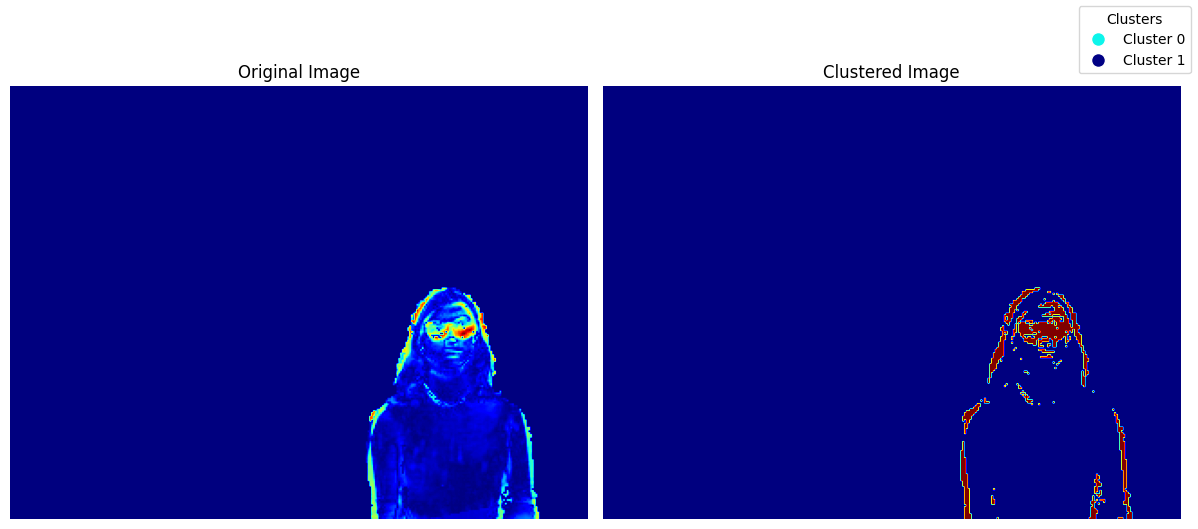

In [175]:

image = hsvImg2_diff[:,:,2]

# Reshape and convert image to float32 for k-means
Z = image.reshape((-1, 1))
Z = np.float32(Z)

# Define k-means criteria and apply k-means - iterations, then epilson
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 5)
K = 2
_, label, center = cv2.kmeans(Z, K, None, criteria, attempts=40, flags=cv2.KMEANS_RANDOM_CENTERS)

# Convert cluster centers to uint8
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((image.shape))

# Create the plot
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Display the original and clustered images
ax[0].imshow(image, cmap='jet')
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(res2, cmap='jet')
ax[1].set_title("Clustered Image")
ax[1].axis('off')

# Add a legend for the clusters
unique_clusters = np.arange(K)  # 0, 1, ..., K-1
colors = [plt.cm.jet(c / 255) for c in center.flatten()]  # Map grayscale to colors
legend_labels = [f"Cluster {i}" for i in unique_clusters]

# Create legend entries
legend_patches = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
    for color in colors
]
fig.legend(legend_patches, legend_labels, loc='upper right', title="Clusters")

plt.tight_layout()
plt.show()


##### Plot the K-Means Clustering Results

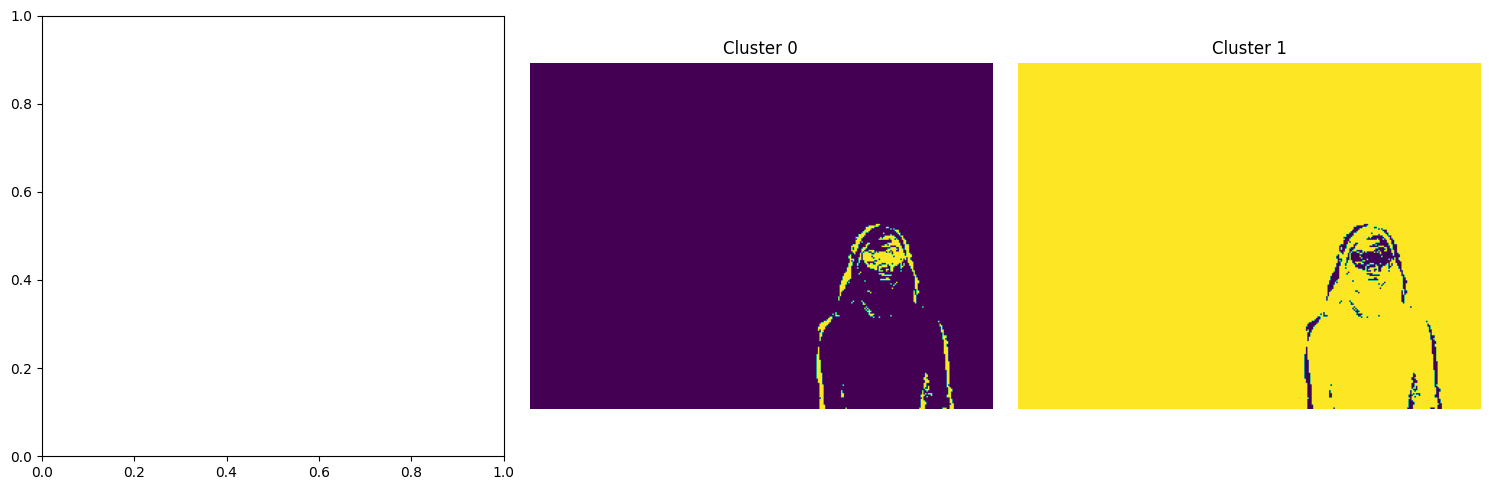

In [176]:
fig, axes = plt.subplots(1, K+1, figsize=(15, 5))


for cluster_to_plot in range(K):
    mask = (label.flatten() == cluster_to_plot).astype(np.uint8)  # Mask for current cluster
    single_cluster = mask.reshape(image.shape) * center[cluster_to_plot]  # Isolated cluster
    
    axes[cluster_to_plot + 1].imshow(single_cluster)
    axes[cluster_to_plot + 1].set_title(f"Cluster {cluster_to_plot}")
    axes[cluster_to_plot + 1].axis('off')

plt.tight_layout()
plt.show()


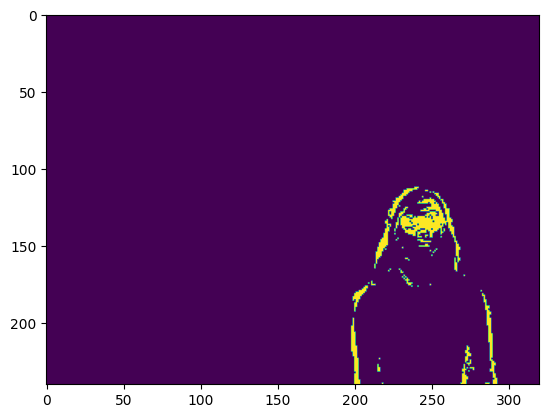

In [177]:
cluster_to_plot = 0  # Change this to the desired cluster index
mask = (label.flatten() == cluster_to_plot).astype(np.uint8)  # Create a mask for the cluster
single_cluster = mask.reshape(image.shape) * center[cluster_to_plot]  # Apply the mask

plt.imshow(single_cluster)

## Step 7: Thresholding for Masking

#### Older Thresholding Attempts

In [160]:


# #HYPERPARAMETERS:
# binary_threshold_1 = 8 #How intense the original pixels must be to be kept
# kern_1 = (2,2) #Kernel to remove the thin edges (smaller kernel keeps smaller edges)
# conn_1 = 8 #tells us how many 'on' pixels each pixel must be touching to be kept - must be 4 or 8
# min_area_1 = 500 #The minimum areas that must be filled in to keep


# #RGB  HSv
# # Threshold the image to binary (adjust threshold as needed)
# # _, binary = cv2.threshold(diff_array, binary_threshold_1, 255, cv2.THRESH_BINARY)
# binary = cv2.adaptiveThreshold(single_cluster,255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 20)

# # First pass to remove thin edges
# kernel_1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kern_1)  # Small kernel
# cleaned_1 = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_1)

# # Ensure the cleaned image is binary and of correct type
# cleaned_binary_1 = cleaned_1.astype(np.uint8)

# # Remove small connected components from the first pass
# num_labels_1, labels_1, stats_1, _ = cv2.connectedComponentsWithStats(cleaned_binary_1, connectivity=conn_1)

# filtered_1 = np.zeros_like(cleaned_binary_1)
# for i in range(1, num_labels_1):  # Skip background label 0
#     if stats_1[i, cv2.CC_STAT_AREA] >= min_area_1:
#         filtered_1[labels_1 == i] = 255

# plt.figure(figsize=(25, 15))
# plt.subplot(1, 5, 1)
# plt.title('Original Grayscale')
# plt.imshow(single_cluster, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 2)
# plt.title('Adaptive Thresholding')
# plt.imshow(binary, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 3)
# plt.title('Morphological ')
# plt.imshow(filtered_1, cmap='gray')
# plt.axis('off')

##### Try Adapative Thresholding (Sucks)

In [161]:
# diff_trans_array = np.array(diff_trans)
# print(type(diff_trans_array[0]))

# cv2.cvtColor(diff_trans_array, cv2.COLOR_BGR2HSV)

# plt.imshow(diff_trans_array)

In [162]:
# max_value = np.max(diff_trans)
# print(f"Maximum value in the HSV image: {max_value}")

# # If you want the maximum value per channel:
# h, s, v = cv2.split(hsvImg2)
# max_hue = np.max(h)          # Max in Hue channel
# max_saturation = np.max(s)   # Max in Saturation channel
# max_value_channel = np.max(v) # Max in Value channel

# print(max_hue)
# print(max_saturation)
# print(max_value_channel)

In [163]:


# #Try to run on the Original Masked Image
# #Original = colour_img2
# #HSV original - hsvImg2
# #Each channel of HSV original

# adapted = cv2.adaptiveThreshold(single_cluster, maxValue=255, adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, thresholdType=cv2.THRESH_BINARY, blockSize=3, C=1)

# plt.imshow(adapted)

In [164]:
# # # Example: Compute the difference
# # diff_og_trans = ImageChops.difference(col_image2, col_image3) 
# # diff_array = np.array(diff_og_trans)

# # # Convert the difference to 8-bit grayscale
# # # diff_array = cv2.cvtColor(diff_array, cv2.COLOR_BGR2GRAY)  # If needed
# # diff_array = diff_array.astype(np.uint8)

# # Apply thresholds
# ret, th1 = cv2.threshold(single_cluster, 50, 255, cv2.THRESH_BINARY)
# th2 = cv2.adaptiveThreshold(single_cluster, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 33, 5)
# th3 = cv2.adaptiveThreshold(single_cluster, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
#                             cv2.THRESH_BINARY, 11, 1)

# # Visualization
# titles = ['Original Image', 'Global Thresholding (v = 55)',
#           'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
# images = [single_cluster, th1, th2, th3]

# for i in range(4):
#     plt.subplot(2, 2, i + 1)
#     plt.imshow(images[i], 'gray')
#     plt.title(titles[i])
#     plt.xticks([]), plt.yticks([])
# plt.show()


In [165]:
# # diff_og_trans = ImageChops.difference(col_image2, col_image3) 
# # diff_array = np.array(diff_og_trans)

# # print(max(diff_array.any))
# # Define a threshold value (e.g., 50)
# #threshold = 40
# kernel = np.ones((3, 3), np.uint8)
# # kernel = np.array([[-1,-1,-1], [-1,9,-1], [-1,-1,-1]])
# # closing = cv.morphologyEx(img, cv.MORPH_CLOSE, kernel)

# closed_edges = cv2.morphologyEx(single_cluster, cv2.MORPH_CLOSE, kernel)

# # sharpened = cv2.filter2D(closed_edges, -1, kernel) # applying the sharpening kernel to the input image & displaying it.

# # # Apply the threshold: Set all values below the threshold to 0
# # #thresholded_diff = np.where(diff_array > threshold, diff_array, 0)

# # # Convert the thresholded result back to an image
# # thresholded_image = Image.fromarray(closed_edges.astype(np.uint8))

# # # Display or save the thresholded image
# # plt.figure(figsize=(18, 6))

# # Plot original image2
# plt.subplot(1, 2, 1)
# plt.title("Original Open ")
# plt.imshow(closed_edges)

# # # Plot transformed image2
# # plt.subplot(1, 2, 2)
# # plt.title("Sharpened")
# # plt.imshow(sharpened)

In [166]:
# import scipy.ndimage as nd
# from skimage.feature import canny

# # # Assuming col_image1 and col_image3 are PIL images
# # diff_og_trans = ImageChops.difference(col_image2, col_image3) 
# # diff = np.array(diff_og_trans)
# # diff = cv2.cvtColor(diff_array, cv2.COLOR_RGB2GRAY)
 
# # apply edge segmentation
# # plot canny edge detection
# edges = canny(single_cluster)

# fill_im = nd.binary_fill_holes(single_cluster - 1)
# plt.imshow(fill_im)
# plt.title('Region Filling')

In [167]:
# # Assuming col_image1 and col_image3 are PIL images
# diff_og_trans = ImageChops.difference(col_image2, col_image3) 
# diff_array = np.array(diff_og_trans)

# # Ensure the image is grayscale (single channel)
# if len(diff_array.shape) == 3:  # Multi-channel image
#     diff_array = cv2.cvtColor(diff_array, cv2.COLOR_BGR2GRAY)


# #HYPERPARAMETERS:
# binary_threshold_1 = 15 #How intense the original pixels must be to be kept
# kern_1 = (1, 1) #Kernel to remove the thin edges (smaller kernel keeps smaller edges)
# conn_1 = 8 #tells us how many 'on' pixels each pixel must be touching to be kept - must be 4 or 8
# min_area_1 = 200 #The minimum areas that must be filled in to keep


# kern_2 = (3,3) #Kernel to remove the thin edges (smaller kernel keeps smaller edges) - second pass
# conn_2 = 8 #tells us how many 'on' pixels each pixel must be touching to be kept - must be 4 or 8
# conn_3 = 8 #tells us how many 'on' pixels each pixel must be touching to be kept - must be 4 or 8
# min_area_2 = 600  # Slightly larger threshold for second pass
# binary_threshold_2 = 120 #How intense the  pixels must be to be kept
# min_area_3 = 850  # Slightly larger threshold for second pass
# kern_3 = (7,7)
# #RGB  HSv
# # Threshold the image to binary (adjust threshold as needed)
# # _, binary = cv2.threshold(diff_array, binary_threshold_1, 255, cv2.THRESH_BINARY)
# binary = cv2.adaptiveThreshold(diff_array, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 1)

# # First pass to remove thin edges
# kernel_1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kern_1)  # Small kernel
# cleaned_1 = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel_1)

# # Ensure the cleaned image is binary and of correct type
# cleaned_binary_1 = cleaned_1.astype(np.uint8)

# # Remove small connected components from the first pass
# num_labels_1, labels_1, stats_1, _ = cv2.connectedComponentsWithStats(cleaned_binary_1, connectivity=conn_1)

# filtered_1 = np.zeros_like(cleaned_binary_1)
# for i in range(1, num_labels_1):  # Skip background label 0
#     if stats_1[i, cv2.CC_STAT_AREA] >= min_area_1:
#         filtered_1[labels_1 == i] = 255


# # Second pass to remove remaining edges or artifacts
# kernel_2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kern_2)  # Slightly larger kernel
# cleaned_2 = cv2.morphologyEx(filtered_1, cv2.MORPH_CLOSE, kernel_2)

# # Remove small connected components again
# num_labels_2, labels_2, stats_2, _ = cv2.connectedComponentsWithStats(cleaned_2, connectivity=conn_2)
# #min_area_2 = 800  # Slightly larger threshold for second pass
# filtered_2 = np.zeros_like(cleaned_2)
# for i in range(1, num_labels_2):  # Skip background label 0
#     if stats_2[i, cv2.CC_STAT_AREA] >= min_area_2:
#         filtered_2[labels_2 == i] = 255


# _, binary2 = cv2.threshold(filtered_1, binary_threshold_2, 255, cv2.THRESH_BINARY)
# kernel_3 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kern_3)  # Small kernel

# cleaned_3 = cv2.morphologyEx(filtered_2, cv2.MORPH_CLOSE, kernel_3)

# # Remove small connected components again
# num_labels_3, labels_3, stats_3, _ = cv2.connectedComponentsWithStats(cleaned_3, connectivity=conn_3)
# filtered_3 = np.zeros_like(cleaned_3)
# for i in range(1, num_labels_3):  # Skip background label 0
#     if stats_3[i, cv2.CC_STAT_AREA] >= min_area_3:
#         filtered_3[labels_3 == i] = 255
# # Visualize results

# plt.figure(figsize=(15, 5))
# plt.subplot(1, 5, 1)
# plt.title('Original Grayscale')
# plt.imshow(diff_array, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 2)
# plt.title('Binary Threshold')
# plt.imshow(binary, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 3)
# plt.title('After First Pass')
# plt.imshow(filtered_1, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 4)
# plt.title('After Second Pass')
# plt.imshow(filtered_2, cmap='gray')
# plt.axis('off')

# plt.subplot(1, 5, 5)
# plt.title('After Third Pass')
# plt.imshow(filtered_3, cmap='gray')
# plt.axis('off')

# plt.show()


### Step 7a: Fill In Masked Area - Use Morphological Thresholding

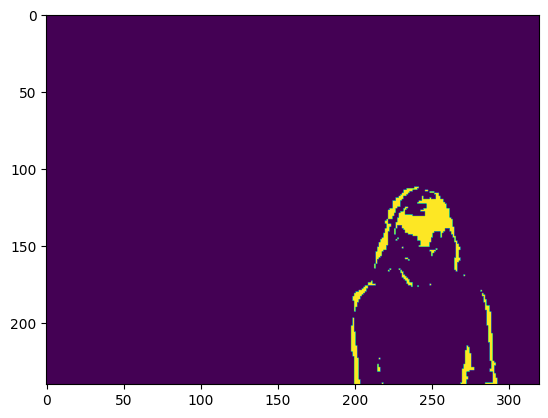

In [178]:

kernel = np.ones((3, 3), np.uint8)

closed_edges = cv2.morphologyEx(single_cluster, cv2.MORPH_CLOSE, kernel)

plt.imshow(closed_edges)



### Step 7b: Denoise the Filled in Mask

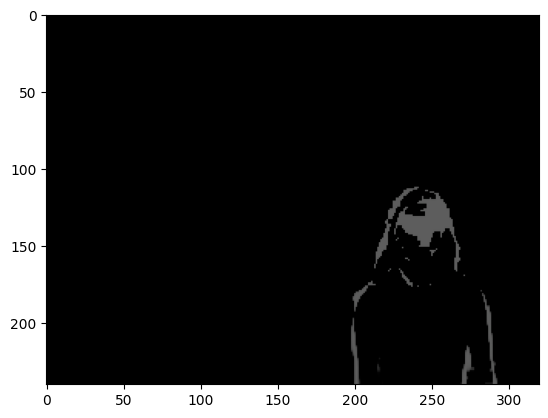

In [179]:
single_cluster_RGB = cv2.cvtColor(closed_edges, cv2.COLOR_GRAY2BGR)  # Convert grayscale to BGR
closed_edges_ary = np.array(single_cluster_RGB)  # Ensure it's in a NumPy array format
dst = cv2.fastNlMeansDenoisingColored(closed_edges_ary, None, h=12, hColor=10, templateWindowSize=100, searchWindowSize=50)

# Display the denoised image
plt.imshow(dst)


### Step 7c: Perform Median Blurring on Denoised Image

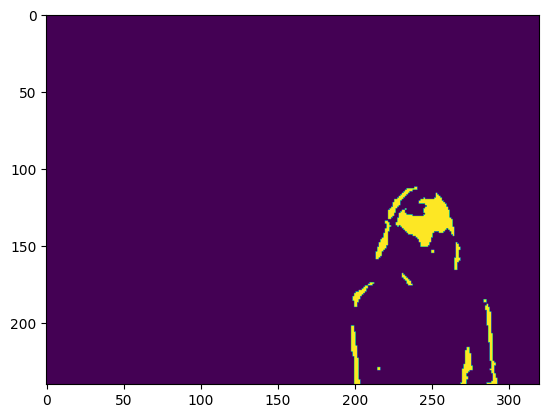

In [180]:
img_gray_blur = cv2.medianBlur(closed_edges, 3) #THIS ONE


plt.imshow(img_gray_blur)

## Step 8: Project Mask onto Occluded Image

Get the sunglasses/ occluded object

(-0.5, 319.5, 239.5, -0.5)

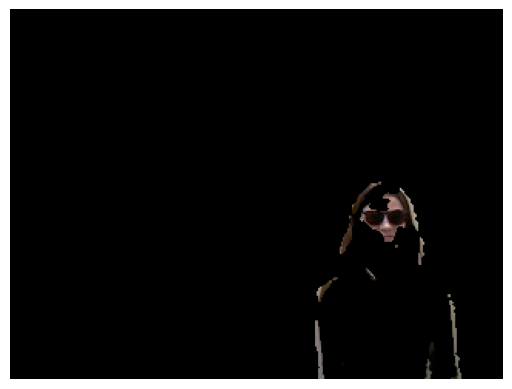

In [181]:
rbg_nonoccluded = np.array(col_image2) # Get the original image 2 to get the mask
rbg_nonoccluded[img_gray_blur == 0] = 0
plt.imshow(rbg_nonoccluded)
plt.axis('off')

Get the region from the non-occluded image

(-0.5, 319.5, 239.5, -0.5)

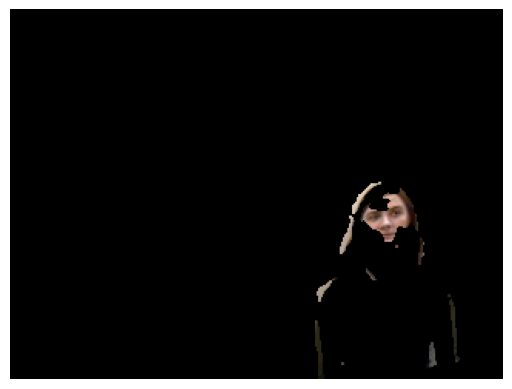

In [188]:
# get region where mask is from non-occluded image

rbg_nonoccluded = np.array(translated_img_colour) # col_image1 is the NON-OCCLUDED original image
rbg_nonoccluded[img_gray_blur == 0] = 0
plt.imshow(rbg_nonoccluded)
plt.axis('off')




(-0.5, 319.5, 239.5, -0.5)

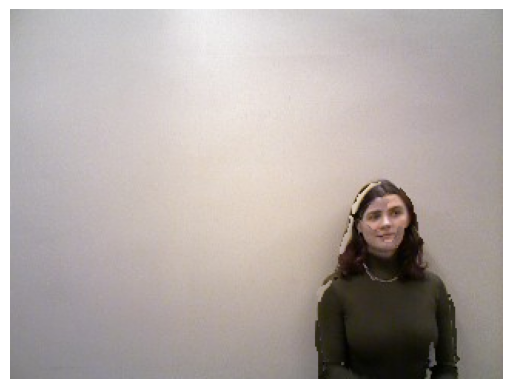

In [189]:
# place the above region on the occluded image

face_seg = rbg_nonoccluded 
mask = np.any(face_seg > 0, axis=-1)
# rbg_mask = np.array(col_image2) # col_image3 is the occluded image!!

rbg_mask = np.array(colour_img2) # col_image3 is the occluded image!!

rbg_mask[mask] = face_seg[mask] # 

plt.imshow(rbg_mask)
plt.axis('off')

# plt.imshow(col_imag e2)